# Train and test tptrans

This notebook: loads the AIS dataset, preprocesses it, splits MMSIs into train/validation/test sets (to avoid track-level leakage), creates `SlidingWindowDataset` instances for each split, trains the `TPTrans` model, and evaluates on the test set.

In [ ]:
# Parameters and imports
import random
import numpy as np
import math
import torch
import os
from torch.utils.data import DataLoader
from dataloader import load_parquet, preprocess_data, SlidingWindowDataset
from tptrans import TPTrans


def tqdm(iterable, **kwargs):
    return iterable

# matplotlib is optional for plotting
try:
    import matplotlib.pyplot as plt
except ImportError:
    plt = None

# Parameters (tweak as needed)
K = 300           # number of MMSIs to sample from dataset/ (k)
WINDOW_MIN = 480      # total window length (minutes)
PRED_MIN = 120         # prediction horizon (minutes)
STRIDE = 30           # sliding stride (minutes)
MAX_DIFF_MIN = 15     # max allowed gap inside a block (minutes)
VAL_MMSI_FRAC = 0.2
TEST_MMSI_FRAC = 0.1
SEED = 42
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-5

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [36]:
# Load and preprocess dataset (this may take a moment depending on 'K')
df = load_parquet('dataset', k=K)
print('Raw loaded rows:', len(df))
df = preprocess_data(df)
print('After preprocess rows:', len(df))

# Ensure MMSI column is string (it should be from loader)
df['MMSI'] = df['MMSI'].astype(str)

/zhome/0a/d/219948/repos/DeepLearning/dataloader.py:168: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")
/zhome/0a/d/219948/repos/DeepLearning/dataloader.py:168: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.set_index("Timestamp")
/zhome/0a/d/219948/repos/DeepLearning/dataloader.py:168: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

Raw loaded rows: 224556
After preprocess rows: 223586


In [37]:
# Split MMSIs into train/val/test (no leakage between splits)
mmsis = sorted(df['MMSI'].unique().tolist())
random.seed(SEED)
random.shuffle(mmsis)
n = len(mmsis)
n_test = max(1, int(n * TEST_MMSI_FRAC))
n_val = max(1, int(n * VAL_MMSI_FRAC))
n_train = n - n_val - n_test
train_mmsis = mmsis[:n_train]
val_mmsis = mmsis[n_train:n_train + n_val]
test_mmsis = mmsis[n_train + n_val:]
print(f'MMSI counts: total={n}, train={len(train_mmsis)}, val={len(val_mmsis)}, test={len(test_mmsis)}')

MMSI counts: total=379, train=267, val=75, test=37


In [38]:
# Build SlidingWindowDataset for each split (the class groups per-MMSI internally)
df_train = df[df['MMSI'].isin(train_mmsis)].reset_index(drop=True)
df_val = df[df['MMSI'].isin(val_mmsis)].reset_index(drop=True)
df_test = df[df['MMSI'].isin(test_mmsis)].reset_index(drop=True)

dataset_train = SlidingWindowDataset(
    df_train,
    max_diff_per_sequence_minutes=MAX_DIFF_MIN,
    window_size_minutes=WINDOW_MIN,
    pred_size_minutes=PRED_MIN,
    stride=STRIDE,
)
dataset_val = SlidingWindowDataset(
    df_val,
    max_diff_per_sequence_minutes=MAX_DIFF_MIN,
    window_size_minutes=WINDOW_MIN,
    pred_size_minutes=PRED_MIN,
    stride=STRIDE,
)
dataset_test = SlidingWindowDataset(
    df_test,
    max_diff_per_sequence_minutes=MAX_DIFF_MIN,
    window_size_minutes=WINDOW_MIN,
    pred_size_minutes=PRED_MIN,
    stride=STRIDE,
)

print('Dataset sizes (windows):', len(dataset_train), len(dataset_val), len(dataset_test))
if len(dataset_train) == 0:
    raise RuntimeError('No training windows generated. Try increasing K or adjusting window/stride parameters.')

Dataset sizes (windows): 21818 5742 2719


In [39]:
# DataLoaders
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

# Build model (infer pred_len from dataset sample)
sample_y = dataset_train[0][1]  # (pred_len, 2)
pred_len = sample_y.shape[0]
print('Inferred pred_len:', pred_len)
model = TPTrans(pred_len=pred_len).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

Inferred pred_len: 20


/zhome/0a/d/219948/repos/DeepLearning/venv/lib64/python3.9/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [40]:
# Training loop (train on train_loader, validate on val_loader)
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    train_loss = running_loss / len(dataset_train)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [val]"):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            val_loss += criterion(pred, y).item() * x.size(0)
    if len(dataset_val) > 0:
        val_loss = val_loss / len(dataset_val)
    else:
        val_loss = float('nan')

    print(f'Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}', flush=True)

    # checkpoint per epoch
    try:
        os.makedirs('checkpoints', exist_ok=True)
        torch.save(model.state_dict(), os.path.join('checkpoints', f'aleksandra_epoch{epoch}.pth'))
    except Exception as e:
        print('Warning: failed to save checkpoint:', e, flush=True)

# After training, evaluate on the test set (compute MSE, RMSE and geodesic errors)
model.eval()
all_mse = 0.0
all_geo = []
count = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        mse_batch = torch.nn.functional.mse_loss(pred, y, reduction='sum').item()
        all_mse += mse_batch
        count += x.size(0)

        # compute haversine per point
        pred_np = pred.cpu().numpy().reshape(-1, 2)
        y_np = y.cpu().numpy().reshape(-1, 2)
        if pred_np.shape[0] > 0:
            lat1 = np.radians(pred_np[:, 0])
            lon1 = np.radians(pred_np[:, 1])
            lat2 = np.radians(y_np[:, 0])
            lon2 = np.radians(y_np[:, 1])
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
            c = 2 * np.arcsin(np.sqrt(a))
            R = 6371000.0
            d = R * c
            all_geo.extend(d.tolist())

mse = all_mse / len(dataset_test)
rmse = math.sqrt(mse)
mean_geo = float(np.mean(all_geo)) if len(all_geo) > 0 else float('nan')
median_geo = float(np.median(all_geo)) if len(all_geo) > 0 else float('nan')
print('Test MSE:', mse, flush=True)
print('Test RMSE:', rmse, flush=True)
print('Mean geodesic error (m):', mean_geo, flush=True)
print('Median geodesic error (m):', median_geo, flush=True)

metrics = {'mse': mse, 'rmse': rmse, 'mean_geodesic_m': mean_geo, 'median_geodesic_m': median_geo}
print('Final test metrics:', metrics, flush=True)

Epoch 1/10 | Train Loss: 1616.602631 | Val Loss: 1598.347043
Epoch 2/10 | Train Loss: 1591.343628 | Val Loss: 1571.851389
Epoch 2/10 | Train Loss: 1591.343628 | Val Loss: 1571.851389
Epoch 3/10 | Train Loss: 1564.213566 | Val Loss: 1543.440654
Epoch 3/10 | Train Loss: 1564.213566 | Val Loss: 1543.440654
Epoch 4/10 | Train Loss: 1533.878931 | Val Loss: 1510.162810
Epoch 4/10 | Train Loss: 1533.878931 | Val Loss: 1510.162810
Epoch 5/10 | Train Loss: 1498.156462 | Val Loss: 1471.562779
Epoch 5/10 | Train Loss: 1498.156462 | Val Loss: 1471.562779
Epoch 6/10 | Train Loss: 1457.361384 | Val Loss: 1428.070484
Epoch 6/10 | Train Loss: 1457.361384 | Val Loss: 1428.070484
Epoch 7/10 | Train Loss: 1411.838794 | Val Loss: 1380.108015
Epoch 7/10 | Train Loss: 1411.838794 | Val Loss: 1380.108015
Epoch 8/10 | Train Loss: 1362.141898 | Val Loss: 1328.343549
Epoch 8/10 | Train Loss: 1362.141898 | Val Loss: 1328.343549
Epoch 9/10 | Train Loss: 1308.948021 | Val Loss: 1273.453861
Epoch 9/10 | Train Loss:

In [41]:
# Optional: save the trained model
import os
CHECKPOINT_DIR = 'checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f'aleksandra_tptrans_k{K}_e{EPOCHS}.pth'))
print('Saved checkpoint to', os.path.join(CHECKPOINT_DIR, f'aleksandra_tptrans_k{K}_e{EPOCHS}.pth'))

Saved checkpoint to checkpoints/aleksandra_tptrans_k500_e10.pth


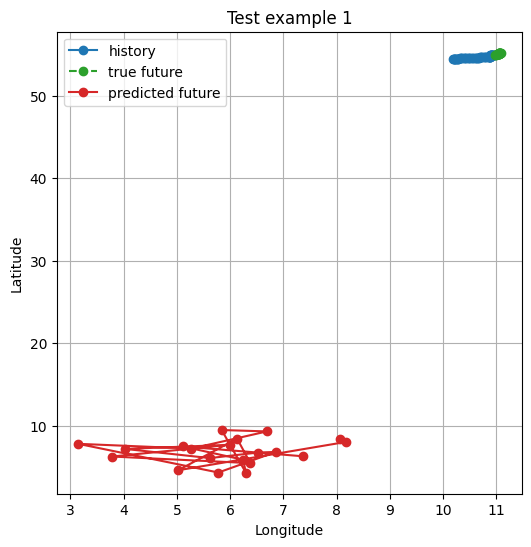

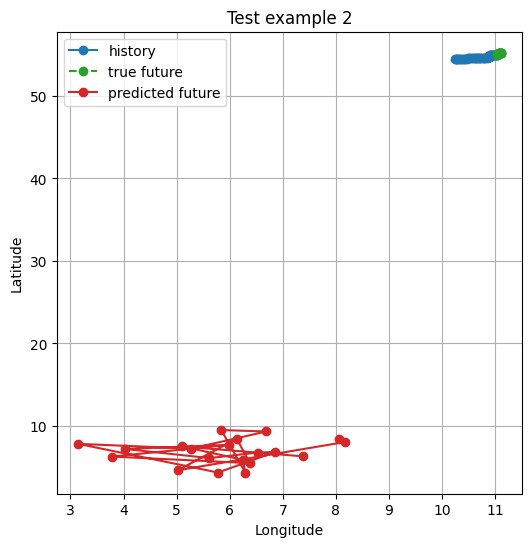

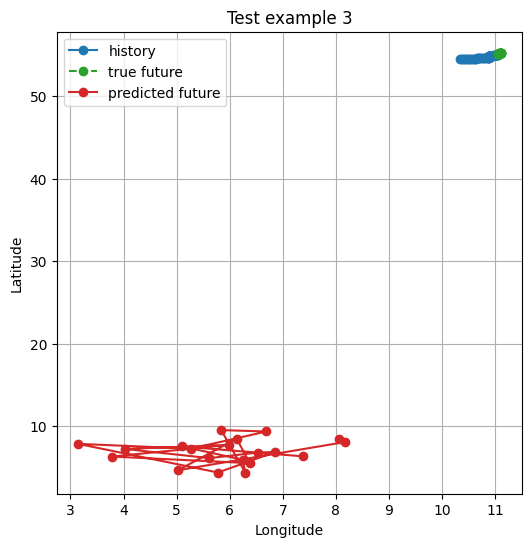

In [42]:
# Visualize a few test examples: history (input), true future, and predicted future
import matplotlib.pyplot as plt

num_examples = 3
examples_plotted = 0
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        x_np = x.cpu().numpy()  # (batch, hist_len, 4)
        y_np = y.cpu().numpy()  # (batch, pred_len, 2)
        pred_np = pred.cpu().numpy()  # (batch, pred_len, 2)

        batch_size = x_np.shape[0]
        for i in range(batch_size):
            hist = x_np[i]
            true_future = y_np[i]
            pred_future = pred_np[i]

            plt.figure(figsize=(6, 6))
            # plot history points (lat, lon) - note: dataloader stores [Latitude, Longitude, SOG, COG]
            plt.plot(hist[:, 1], hist[:, 0], '-o', label='history', color='tab:blue')
            # true future
            plt.plot(true_future[:, 1], true_future[:, 0], '--o', label='true future', color='tab:green')
            # predicted future
            plt.plot(pred_future[:, 1], pred_future[:, 0], '-o', label='predicted future', color='tab:red')

            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title(f'Test example {examples_plotted + 1}')
            plt.legend()
            plt.grid(True)
            plt.show()

            examples_plotted += 1
            if examples_plotted >= num_examples:
                break
        if examples_plotted >= num_examples:
            break